In [1]:
import os
import sys
sys.path.insert(0, os.path.realpath('__file__'))

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pyidi

c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Load the video

In [2]:
filename = 'data/data_synthetic.cih'
video = pyidi.pyIDI(filename)

Video info can easily be accessed (info might not be available depending on video file extension)

In [3]:
video.info

{'Date': '2016/08/31',
 'Camera Type': 1,
 'Record Rate(fps)': 1,
 'Shutter Speed(s)': 1.0,
 'Total Frame': 101,
 'Original Total Frame': 101,
 'Start Frame': 0,
 'Image Width': 256,
 'Image Height': 128,
 'Color Type': 'Mono',
 'Color Bit': 16,
 'File Format': 'MRaw',
 'EffectiveBit Depth': 12,
 'EffectiveBit Side': 'Lower',
 'Comment Text': 'Generated sequence.<br>Modify measurement info in<br>created .cih file if necessary.'}

In [4]:
%matplotlib qt
import matplotlib.animation as animation

def play_video(frame_range = None, interval=30, points = None, ij_counter = (0.65, 0.05)):
    
    """
    Plays the video from the given video object.
    Args:
        frame_range (range object): The range of frames to play.
        interval (int): The interval between frames in milliseconds.
        points (ndarray): Optional tracked points to plot on the video.
        ij_counter (tuple): The position of the frame counter.
    """
    if frame_range is None:
        frame_range = range(0, video.info['Total Frame'])
    fig, ax = plt.subplots()
    im = ax.imshow(video.mraw[frame_range[0]], cmap='gray')
    text = ax.text(ij_counter[0], ij_counter[1], '', transform=ax.transAxes, color='black', ha='right', va='bottom')

    if points is not None:
        pts = ax.plot(points[:,0,1], points[:,0,0], 'r.')

    def update(i):
        im.set_data(video.mraw[i])
        text.set_text(f'Frame {i}')
        if points is not None:
            pts[0].set_data(points[:,i,1], points[:,i,0])
        return im, text

    ani = animation.FuncAnimation(fig, update, frames=frame_range, interval=interval)
    plt.show()
    return ani

ani = play_video(range(1, video.info['Total Frame']))

c:\Users\thijsmas\Documents\GitHub\pyidi\pyidi\pyidi.py:275: DeprecationWarning: `self.mraw` is deprecated and will be removed in the next version. Please use `self.reader.mraw` instead.
  warnings.warn('`self.mraw` is deprecated and will be removed in the next version. Please use `self.reader.mraw` instead.', DeprecationWarning)


We will first use the `Lucas Kanade` method as a reference

In [5]:
%matplotlib qt
tol = 1e-8
roi_size = (5,5)
video = pyidi.pyIDI(filename)
video.set_method('lk')
video.method.configure(reference_image = (0,100), resume_analysis = False, tol=tol, roi_size=roi_size)
reference_image = video.method._set_reference_image(video, video.method.reference_image)
Gi, Gj = np.gradient(reference_image)
G = np.sqrt(Gi**2 + Gj**2)
highest_points = np.argpartition(G.flatten(), -10)[-10:]
arguments = np.unravel_index(highest_points, G.shape)

fig, ax = plt.subplots()
ax.scatter(arguments[1], arguments[0])
ax.imshow(reference_image, cmap='gray')
plt.show()
points2d = np.array(arguments).T
video.set_points(points2d)
video.show_points()
displacementes_2d = video.get_displacements(processes=1, autosave=False)

--- Starting new analysis ---
 
Interpolating the reference image...
...done in 0.00 s


c:\Users\thijsmas\Documents\GitHub\pyidi\pyidi\methods\_lucas_kanade.py:568: ResourceWarning: unclosed file <_io.BufferedReader name='data\\temp_file\\settings.pkl'>
  settings_old = pickle.load(open(self.settings_filename, 'rb'))
c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


VBox()

Time to complete: 0.7 s


Next we will first use the `Directional - Lucas Kanade` method

In [6]:
%matplotlib qt
video = pyidi.pyIDI(filename)
video.set_method('lk_1D')
'''
 Here we define the direction of the motion
'''
dij = (0.5, 0.5) 
video.method.configure(reference_image = (0,100), dyx=dij, resume_analysis = False, tol=tol,roi_size=roi_size)
reference_image = video.method._set_reference_image(video, video.method.reference_image)
Gi, Gj = np.gradient(reference_image)
G = np.sqrt(Gi**2 + Gj**2)
highest_points = np.argpartition(G.flatten(), -10)[-10:]
arguments = np.unravel_index(highest_points, G.shape)

fig, ax = plt.subplots()
ax.scatter(arguments[1], arguments[0])
ax.imshow(reference_image, cmap='gray')
plt.show()
points1d = np.array(arguments).T
video.set_points(points1d)
video.show_points()
video.method.dyx

c:\Users\thijsmas\Documents\GitHub\pyidi\pyidi\methods\_directional_lucas_kanade.py:124: UserWarning: The direction vector d must have a norm of 1. The input vector was normalized.
  warnings.warn('The direction vector d must have a norm of 1. The input vector was normalized.')


array([0.70710678, 0.70710678])

In [8]:
displacements = video.get_displacements(processes=2, autosave=False)

--- Starting new analysis ---
 
Computation start: 2024-10-11 14:50:25.475026


VBox()

Computation duration: 00:00:4.37


An existing analysis can also be loaded without computation and setting the arguments.

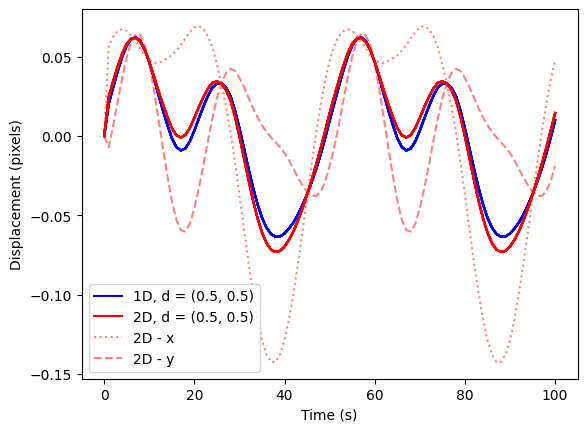

In [9]:
%matplotlib inline
t_vec = np.arange(0, len(displacements[0])) * video.info['Record Rate(fps)']

fig, ax = plt.subplots()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Displacement (pixels)')
for point in displacements:
    # ax.plot(t_vec, point[:,0],'b:')
    # ax.plot(t_vec, point[:,1],'b--')
    ax.plot(t_vec, point[:,0]*dij[0] + point[:,1]*dij[1],'b', label=f'1D, d = {dij}')
for point in displacementes_2d:
    ax.plot(t_vec, point[:,0]*dij[0] + point[:,1]*dij[1], 'r', label=f'2D, d = {dij}')
ax.plot(t_vec, displacementes_2d[0, :,0], 'r:', label = '2D - x', alpha=0.5)
ax.plot(t_vec, displacementes_2d[0, :,1], 'r--', label = '2D - y', alpha=0.5)
# ax.plot(t_vec, np.arctan2(displacementes_2d[0, :,1], displacementes_2d[0, :,0]), 'r--', label = 'direction', alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
plt.show()

In [10]:
%matplotlib qt
td2d     = displacementes_2d +  points2d.reshape(len(points2d),1,2)
td1d     = displacements +  points1d.reshape(len(points1d),1,2)
ani = play_video(range(1,video.reader.N), points=td1d)